# Analyse Morris results

In [34]:
import pandas as pd
import seaborn as sns
import re

Run with `dakota -i ia.in > morris_summary.out`: only `>` gets results written to file.

In [35]:
# Must be am easier way to get Dakota results out...
# Read in .out file (contains summary results)

output_files = ["morris_lt_summary.out", "morris_lt_max_net_elec_summary.out"]

# Match line in output
input_re = re.compile(r"Input\s+(\d+)\s.*=\s+(\d+\.\d+e[+-]\d+)\s+(\d+\.\d+e[+-]\d+)")
results = {"design": [], "input": [], "descriptor": [], "mod_mean": [], "std": []}

descriptors = [
    "fdene",
    "hfact",
    "coreradius",
    "fimp_2",
    "fimp_14",
    "psepbqarmax",
    "flhthresh",
    "cboot",
    "peakfactrad",
    "kappa",
    "etaech",
    "feffcd",
    "etath",
    "etaiso",
    "boundl_18",
    "pinjalw",
    "alstroh",
    "sig_tf_wp_max",
    "aspect",
    "boundu_2",
    "triang",
]

for output_file in output_files:
    design_and_suffix = output_file.split("morris_")[1]
    design = design_and_suffix.split("_summary.out")[0]
    with open(output_file, "r") as f:
        content = f.readlines()

    for line in content:
        if matches := input_re.match(line):
            # Start of results
            results["design"].append(design)
            results["input"].append(float(matches[1]))
            # TODO Improve this! Risk of descriptors and input number getting out of sync
            results["descriptor"].append(descriptors[int(matches[1]) - 1])
            results["mod_mean"].append(float(matches[2]))
            results["std"].append(float(matches[3]))
        else:
            continue

results_df = pd.DataFrame(results)
results_df

,design,input,descriptor,mod_mean,std
0,lt,1.0,fdene,0.000000,0.000000
1,lt,2.0,hfact,0.000000,0.000000
2,lt,3.0,coreradius,0.000000,0.000000
3,lt,4.0,fimp_2,0.000000,0.000000
4,lt,5.0,fimp_14,0.790550,0.909250
5,lt,6.0,psepbqarmax,0.000000,0.000000
6,lt,7.0,flhthresh,0.271700,0.363530
7,lt,8.0,cboot,0.168370,0.389250
8,lt,9.0,peakfactrad,0.000000,0.000000
9,lt,10.0,kappa,0.318100,0.508460


Text(0, 0.5, '$\\sigma$')

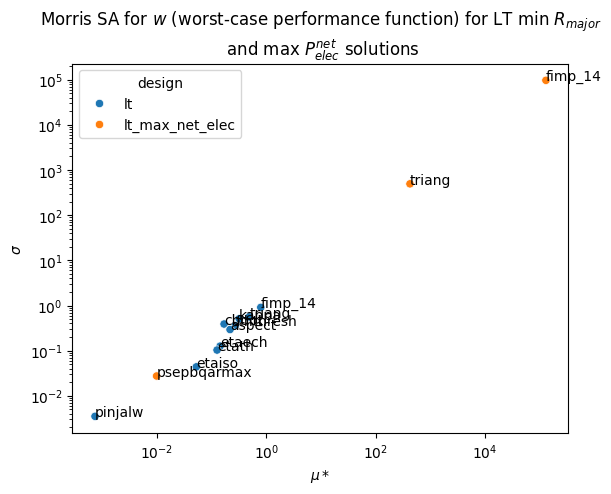

In [72]:
# Plot both designs together
ax = sns.scatterplot(data=results_df, x="mod_mean", y="std", hue="design")

x_offset = 0.0
y_offset = 0.0


def label_point(df):
    for _, row in df.iterrows():
        mod_mean = row["mod_mean"]
        std = row["std"]
        # Only label if not 0: avoid overwriting at same point
        if mod_mean != 0.0 and std != 0.0:
            ax.annotate(text=row["descriptor"], xy=(mod_mean, std))


ax.loglog()
label_point(results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT min $R_{major}$\n"
    " and max $P_{elec}^{net}$ solutions"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

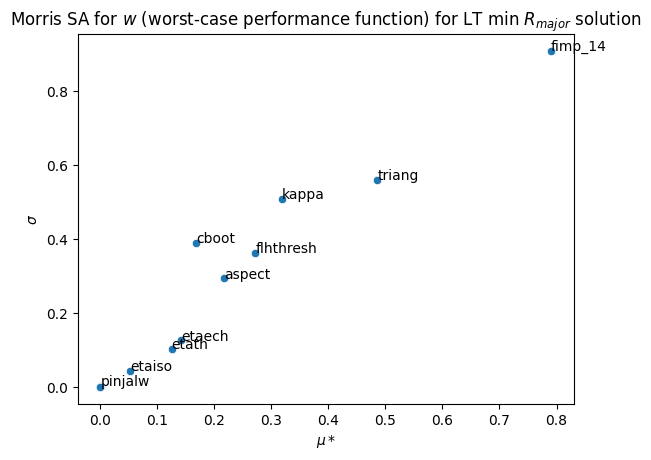

In [66]:
# min rmajor only
lt_results_df = results_df[results_df["design"] == "lt"]
ax = sns.scatterplot(data=lt_results_df, x="mod_mean", y="std")

# ax.loglog()
label_point(lt_results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT min $R_{major}$ solution"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

Text(0, 0.5, '$\\sigma$')

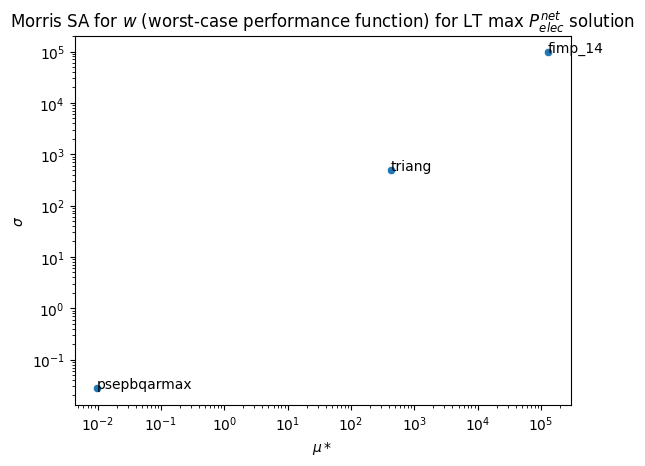

In [70]:
# Max P net elec only
lt_max_net_elec_results_df = results_df[results_df["design"] == "lt_max_net_elec"]
ax = sns.scatterplot(
    data=lt_max_net_elec_results_df,
    x="mod_mean",
    y="std",
)

ax.loglog()
label_point(lt_max_net_elec_results_df)

ax.set_title(
    "Morris SA for $w$ (worst-case performance function) for LT max $P_{elec}^{net}$ solution"
)
ax.set_xlabel("$\mu*$")
ax.set_ylabel("$\sigma$")

## Individual constraint analysis

In [81]:
# Read in individual evaluations
evals = pd.read_csv("morris_lt.dat", sep="\s+")
evals_w_sorted = evals.sort_values(by="w", ascending=False)
evals_w_sorted["w"]

6    0.292256
7    0.292256
1    0.249326
2    0.249326
3    0.249326
4    0.249326
5    0.249326
0    0.231111
Name: w, dtype: float64